In [1]:
import os
import sys
sys.setrecursionlimit(10000)
from os import listdir
import numpy as np
import pydicom
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import glob
import PIL
import random
import seaborn as sns

import cv2
from matplotlib.image import imread
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import plotly.express as px
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:

image_dir = r"C:\Users\DELL\josiah_project\dataset\jpeg"
metadata_file = r"C:\Users\DELL\josiah_project\dataset\csv\dicom_info.csv"


In [4]:
import pandas as pd
metadata_file = pd.read_csv(metadata_file)
print("CSV file loaded successfully.")

CSV file loaded successfully.


In [5]:
metadata_file.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [6]:
metadata_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [7]:
cropped_images = metadata_file[metadata_file['SeriesDescription'] == 'cropped images']['image_path']
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [8]:
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images.head()

0     C:\Users\DELL\josiah_project\dataset\jpeg/1.3....
3     C:\Users\DELL\josiah_project\dataset\jpeg/1.3....
6     C:\Users\DELL\josiah_project\dataset\jpeg/1.3....
7     C:\Users\DELL\josiah_project\dataset\jpeg/1.3....
10    C:\Users\DELL\josiah_project\dataset\jpeg/1.3....
Name: image_path, dtype: object

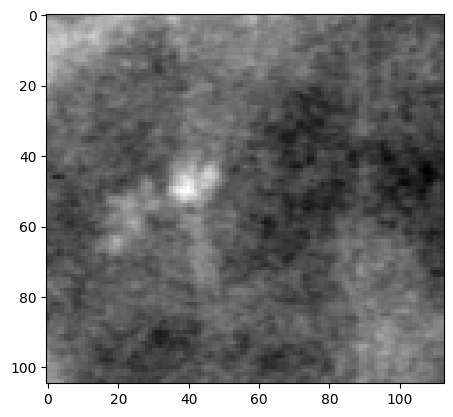

In [9]:
for file in cropped_images[0:10]:
        # try:
            cropped_images_show = PIL.Image.open(file)
            gray_img = cropped_images_show.convert("L")
            plt.imshow(gray_img, cmap='gray')

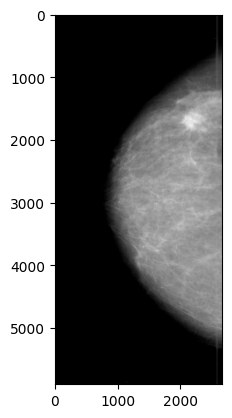

In [10]:
full_mammogram_images = metadata_file[metadata_file['SeriesDescription'] == 'full mammogram images']['image_path']
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

for file  in full_mammogram_images[0:10]:
    full_mammogram_images_show = PIL.Image.open(file)
    gray_img= full_mammogram_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

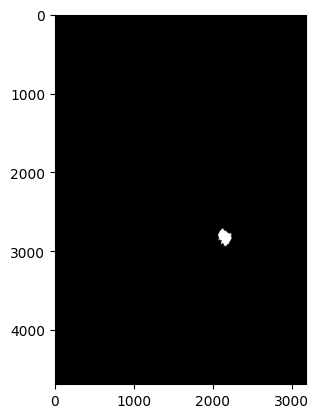

In [11]:
ROI_mask_images = metadata_file[metadata_file['SeriesDescription'] == 'ROI mask images']['image_path']
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

for file  in ROI_mask_images[0:10]:
    ROI_mask_images_show = PIL.Image.open(file)
    gray_img= ROI_mask_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [12]:
calc_case_df = pd.read_csv(r"C:\Users\DELL\josiah_project\dataset\csv\calc_case_description_train_set.csv")

mass_case_df = pd.read_csv(r"C:\Users\DELL\josiah_project\dataset\csv\mass_case_description_train_set.csv")


In [13]:
calc_case_df.head(5)

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [14]:

mass_case_df.head(5)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [15]:
metadata_cleaned_file = metadata_file.copy()

metadata_cleaned_file.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True) 

metadata_cleaned_file['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)

metadata_cleaned_file['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

metadata_cleaned_file.isna().sum()

C:\Users\DELL\AppData\Local\Temp\ipykernel_19168\3191552530.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata_cleaned_file['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19168\3191552530.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  metadata_cleaned_file['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)
C:\Users\DELL\AppData\Local\Temp\ip

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

In [16]:

Data_cleaning_1 = calc_case_df.copy()
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc type':'calc_type'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc distribution':'calc_distribution'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'image view':'image_view'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'breast density':'breast_density'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_1['pathology'] = Data_cleaning_1['pathology'].astype('category')
Data_cleaning_1['calc_type'] = Data_cleaning_1['calc_type'].astype('category')
Data_cleaning_1['calc_distribution'] = Data_cleaning_1['calc_distribution'].astype('category')
Data_cleaning_1['abnormality_type'] = Data_cleaning_1['abnormality_type'].astype('category')
Data_cleaning_1['image_view'] = Data_cleaning_1['image_view'].astype('category')
Data_cleaning_1['left_or_right_breast'] = Data_cleaning_1['left_or_right_breast'].astype('category')
Data_cleaning_1.isna().sum()


patient_id                   0
breast_density               0
left_or_right_breast         0
image_view                   0
abnormality id               0
abnormality_type             0
calc_type                   20
calc_distribution          376
assessment                   0
pathology                    0
subtlety                     0
image file path              0
cropped image file path      0
ROI mask file path           0
dtype: int64

In [17]:
Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_1['calc_distribution'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_1.isna().sum()

C:\Users\DELL\AppData\Local\Temp\ipykernel_19168\2703319416.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19168\2703319416.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19168\2703319416.py:

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [18]:
Data_cleaning_2 = mass_case_df.copy()
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass shape':'mass_shape'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass margins':'mass_margins'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'image view':'image_view'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_2['left_or_right_breast'] = Data_cleaning_2['left_or_right_breast'].astype('category')
Data_cleaning_2['image_view'] = Data_cleaning_2['image_view'].astype('category')
Data_cleaning_2['mass_margins'] = Data_cleaning_2['mass_margins'].astype('category')
Data_cleaning_2['mass_shape'] = Data_cleaning_2['mass_shape'].astype('category')
Data_cleaning_2['abnormality_type'] = Data_cleaning_2['abnormality_type'].astype('category')
Data_cleaning_2['pathology'] = Data_cleaning_2['pathology'].astype('category')
Data_cleaning_2.isna().sum()


patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [19]:

Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_2['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_2.isna().sum()

C:\Users\DELL\AppData\Local\Temp\ipykernel_19168\319634075.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19168\319634075.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19168\319634075.py:2

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [18]:
breast_imgs = glob.glob('C:/Users/DELL/josiah_project/breast-histopathology-images/**/*.png', recursive = True)


In [19]:

for imgname in breast_imgs[:5]:
    print(imgname)

C:/Users/DELL/josiah_project/breast-histopathology-images\10253\0\10253_idx5_x1001_y1001_class0.png
C:/Users/DELL/josiah_project/breast-histopathology-images\10253\0\10253_idx5_x1001_y1051_class0.png
C:/Users/DELL/josiah_project/breast-histopathology-images\10253\0\10253_idx5_x1001_y1101_class0.png
C:/Users/DELL/josiah_project/breast-histopathology-images\10253\0\10253_idx5_x1001_y1151_class0.png
C:/Users/DELL/josiah_project/breast-histopathology-images\10253\0\10253_idx5_x1001_y1201_class0.png


In [20]:
non_cancer_imgs = []
cancer_imgs = []

for img in breast_imgs:
    if img[-5] == '0' :
        non_cancer_imgs.append(img)
    
    elif img[-5] == '1' :
        cancer_imgs.append(img)

In [21]:
non_cancer_num = len(non_cancer_imgs)  # No cancer
cancer_num = len(cancer_imgs)   # Cancer 
        
total_img_num = non_cancer_num + cancer_num
        
print('Number of Images of no cancer: {}' .format(non_cancer_num))   # images of Non cancer
print('Number of Images of cancer : {}' .format(cancer_num))   # images of cancer 
print('Total Number of Images : {}' .format(total_img_num))

Number of Images of no cancer: 397476
Number of Images of cancer : 157572
Total Number of Images : 555048


In [24]:
data_insight_1 = pd.DataFrame({'state of cancer' : ['0','1'],'Numbers of Patients' : [198738,78786]})


In [25]:

# import plotly.express as px
# bar = px.bar(data_frame=data_insight_1, x = 'state of cancer', y='Numbers of Patients', color='state of cancer')
# bar.update_layout(title_text='Number of Patients with cancer (1) and patients with no cancer (0)', title_x=0.5)
# bar.show()

In [26]:
r= pd.DataFrame(metadata_cleaned_file['SeriesDescription'].value_counts())
r= r.reset_index()
r= r.rename(columns={'SeriesDescription':'SeriesDescription_counts', 'index':'SeriesDescription'})
r

,SeriesDescription_counts,count
0,cropped images,3859
1,ROI mask images,3340
2,full mammogram images,3038


In [27]:
# ba_1 = px.bar(data_frame=metadata_cleaned_file, x='SeriesDescription', color='SeriesDescription',
#               title='Types of images used')
# ba_1.update_layout(title_text='Types of images used', title_x=0.5)
# ba_1.show()

In [28]:
data_insight_2 = pd.DataFrame({'abnormality':[Data_cleaning_1.abnormality_type[0],Data_cleaning_2.abnormality_type[0]],
                               'counts_of_abnormalties':[len(Data_cleaning_1),len(Data_cleaning_2)]})
data_insight_2

,abnormality,counts_of_abnormalties
0,calcification,1546
1,mass,1318


In [29]:
# bar_2 =px.bar(data_frame=data_insight_2, x = 'abnormality', y='counts_of_abnormalties', color = 'abnormality')
# bar_2.update_layout(title_text='Types of abnormalites of cancer', title_x=0.5)
# bar_2.show()

In [30]:
x = Data_cleaning_1.left_or_right_breast.value_counts().RIGHT
y = Data_cleaning_1.left_or_right_breast.value_counts().LEFT
print(x,y)

728 818


In [31]:
data_insight_3 = pd.DataFrame({'left_or_right_breast':['RIGHT','LEFT'] , 'Counts':[x,y]})
data_insight_3

,left_or_right_breast,Counts
0,RIGHT,728
1,LEFT,818


In [32]:
# insight_3 = px.bar(data_insight_3, y= 'Counts', x='left_or_right_breast',color = 'left_or_right_breast')
# insight_3.update_layout(title_text=' clacification cancer position of the breasts ', title_x=0.5)
# insight_3.show()

In [33]:
z = pd.DataFrame(Data_cleaning_1['calc_type'].value_counts())
z = z.reset_index()
z= z.rename(columns={'calc_type':'calc_type_counts'})
z

,calc_type_counts,count
0,PLEOMORPHIC,664
1,AMORPHOUS,139
2,PUNCTATE,106
3,LUCENT_CENTER,93
4,VASCULAR,82
5,FINE_LINEAR_BRANCHING,77
6,COARSE,35
7,ROUND_AND_REGULAR-LUCENT_CENTER,33
8,PLEOMORPHIC-FINE_LINEAR_BRANCHING,28
9,ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE,24


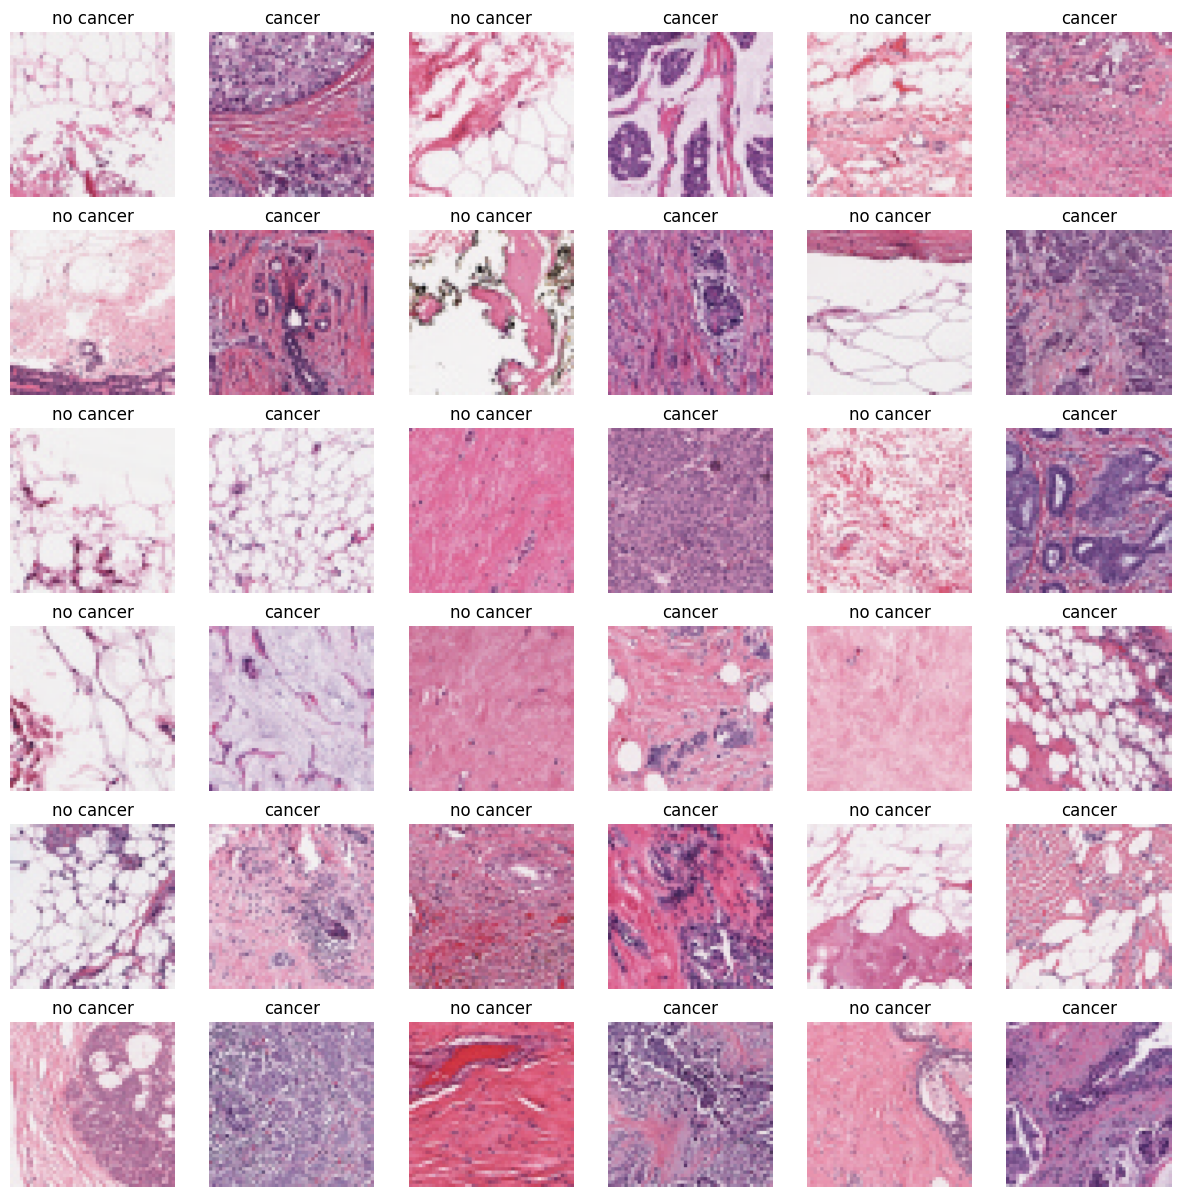

In [22]:
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(non_cancer_imgs), 18)
some_can = np.random.randint(0, len(cancer_imgs), 18)

s = 0
for num in some_non:
    
        img = image.load_img((non_cancer_imgs[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
        
s = 1
for num in some_can:
    
        img = image.load_img((cancer_imgs[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('cancer')
        plt.imshow(img.astype('uint8'))         
        s += 1

In [27]:
# Randomly sample images from two lists, 'non_cancer_imgs' and 'cancer_imgs'
some_non_img = random.sample(non_cancer_imgs, len(non_cancer_imgs))
some_can_img = random.sample(cancer_imgs, len(cancer_imgs))

# Initialize empty arrays to store image data and labels
non_img_arr = []  # Array for non-cancer images
can_img_arr = []  # Array for cancer images

# Loop through each image in the 'some_non_img' list
for img in some_non_img:
    # Read the image in color mode
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    # Resize the image to a fixed size (50x50 pixels) using linear interpolation
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 0 (indicating non-cancer) to the 'non_img_arr'
    non_img_arr.append([n_img_size, 0])

# Loop through each image in the 'some_can_img' list
for img in some_can_img:
    # Read the image in color mode
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    # Resize the image to a fixed size (50x50 pixels) using linear interpolation
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 1 (indicating cancer) to the 'can_img_arr'
    can_img_arr.append([c_img_size, 1])

In [28]:
print("Length of non_img_arr:", len(non_img_arr))
print("Length of can_img_arr:", len(can_img_arr))
print("Type of elements in non_img_arr:", type(non_img_arr[0]))
print("Type of elements in can_img_arr:", type(can_img_arr[0]))

# Assuming non_img_arr and can_img_arr are lists of tuples (feature, label)
print("Type of first feature in non_img_arr:", type(non_img_arr[0][0]))
print("Type of first label in non_img_arr:", type(non_img_arr[0][1]))
print("Shape of first feature in non_img_arr:", np.array(non_img_arr[0][0]).shape)
print("Shape of first feature in can_img_arr:", np.array(can_img_arr[0][0]).shape)


Length of non_img_arr: 397476
Length of can_img_arr: 157572
Type of elements in non_img_arr: <class 'list'>
Type of elements in can_img_arr: <class 'list'>
Type of first feature in non_img_arr: <class 'numpy.ndarray'>
Type of first label in non_img_arr: <class 'int'>
Shape of first feature in non_img_arr: (50, 50, 3)
Shape of first feature in can_img_arr: (50, 50, 3)


In [29]:
import numpy as np
import random

X = []  # List for image data
y = []  # List for labels

# Combine the lists into a single list
breast_img_arr = non_img_arr + can_img_arr

# Shuffle the combined list
random.shuffle(breast_img_arr)

# Extract features and labels into separate lists
for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Print the shapes of the arrays
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (555048, 50, 50, 3)
y shape: (555048,)


In [30]:
# Split the dataset into training and testing sets, with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [38]:


rate = 0.5


num = int(X.shape[0] * rate)


y_train = to_categorical(y_train, 2)  # Assuming there are 2 classes (non-cancer and cancer)
y_test = to_categorical(y_test, 2)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create data generators for training and testing
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
test_datagen = datagen.flow(X_test, y_test, batch_size=32, shuffle=False)


In [39]:
# Define an EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
    patience=5,                  # Number of epochs with no improvement after which training will be stopped
    min_delta=1e-7,              # Minimum change in the monitored quantity to be considered an improvement
    restore_best_weights=True,   # Restore model weights from the epoch with the best value of monitored quantity
)

# Define a ReduceLROnPlateau callback
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # Monitor the validation loss
    factor=0.2,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
    min_delta=1e-7,       # Minimum change in the monitored quantity to trigger a learning rate reduction
    cooldown=0,           # Number of epochs to wait before resuming normal operation after learning rate reduction
    verbose=1             # Verbosity mode (1: update messages, 0: no messages)
)

checkpoint_cb = ModelCheckpoint("E:/Model_output/best_model.keras", save_best_only=True, monitor="val_loss", mode="min")

In [40]:
# Set a random seed for reproducibility
local_weights_file = r'C:\Users\DELL\josiah_project\vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create the VGG19 model without the top classification layer
base_model = VGG19(weights=None, include_top=False, input_shape=(50, 50, 3))

# Load the weights manually
base_model.load_weights(local_weights_file)

# Freeze the base model
base_model.trainable = False

# Set a random seed for reproducibility
tf.random.set_seed(42)
# Create a Sequential model
model = tf.keras.Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])


In [47]:
# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully.")



NameError: name 'model' is not defined

In [42]:
# Train the model
history = model.fit(
    train_datagen,
    validation_data=test_datagen,
    epochs=25,
    callbacks=[early_stopping, plateau, checkpoint_cb
               
               
               
               
               ]
)

Epoch 1/25


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13877/13877 ━━━━━━━━━━━━━━━━━━━━ 4911s 354ms/step - accuracy: 0.7792 - loss: 0.5663 - val_accuracy: 0.8186 - val_loss: 0.4243 - learning_rate: 0.0010
Epoch 2/25
13877/13877 ━━━━━━━━━━━━━━━━━━━━ 7720s 556ms/step - accuracy: 0.8146 - loss: 0.4248 - val_accuracy: 0.8217 - val_loss: 0.4241 - learning_rate: 0.0010
Epoch 3/25
13877/13877 ━━━━━━━━━━━━━━━━━━━━ 8069s 581ms/step - accuracy: 0.8167 - loss: 0.4201 - val_accuracy: 0.8225 - val_loss: 0.4081 - learning_rate: 0.0010
Epoch 4/25
13877/13877 ━━━━━━━━━━━━━━━━━━━━ 7419s 535ms/step - accuracy: 0.8184 - loss: 0.4186 - val_accuracy: 0.8255 - val_loss: 0.4009 - learning_rate: 0.0010
Epoch 5/25
13877/13877 ━━━━━━━━━━━━━━━━━━━━ 8984s 647ms/step - accuracy: 0.8188 - loss: 0.4177 - val_accuracy: 0.8247 - val_loss: 0.4015 - learning_rate: 0.0010
Epoch 6/25
13877/13877 ━━━━━━━━━━━━━━━━━━━━ 8672s 625ms/step - accuracy: 0.8205 - loss: 0.4144 - val_accuracy: 0.8159 - val_loss: 0.4173 - learning_rate: 0.0010
Epoch 7/25
13877/13877 ━━━━━━━━━━━━━━━━━━━━ 8

BREAST CANCER MODEL TRAINING SESSION TWO

In [53]:
model.save('E:/Model_output/AfyaAI_model_Vgg.keras')

In [94]:
model.save('AfyaAI_model_Vgg.h5')

In [56]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,542,216 (78.36 MB)

 Trainable params: 172,610 (674.26 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 345,222 (1.32 MB)

In [5]:
vgg_model = tf.keras.models.load_model('AfyaAI_model_Vgg.h5')

In [4]:
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.losses import categorical_crossentropy  \

vgg_model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [6]:
dummy_input = tf.zeros((1, 50, 50, 3))  # Replace with your image input shape
vgg_model(dummy_input)

<tf.Tensor: shape=(1, 1, 1, 512), dtype=float32, numpy=
array([[[[4.80877757e-02, 0.00000000e+00, 0.00000000e+00,
          5.92248142e-03, 7.76462197e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          2.85976946e-01, 0.00000000e+00, 0.00000000e+00,
          1.05287820e-01, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 8.75235915e-01,
          0.00000000e+00, 1.04651451e-02, 0.00000000e+00,
          3.84639919e-01, 0.00000000e+00, 1.71686307e-01,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          3.53975594e-01, 0.00000000e+00, 0.00000000e+00,
          2.04025820e-01, 0.00000000e+00, 0.00000000e+00,
          0.0000

In [13]:
from tensorflow.keras.applications import ResNet50

# Load pre-trained ResNet50 without the final classification layers
resnet_model = ResNet50(weights='imagenet', include_top=False)

# Ensure the model is built (important step)
dummy_input = tf.zeros((1, 50, 50, 3))  # Replace with your image input shape
resnet_model(dummy_input)

# Create a feature extractor model up to the layer before Flatten (assuming 'conv5_block3_out')
resnet_feature_extractor = tf.keras.Model(inputs=resnet_model.input, outputs=resnet_model.get_layer('conv5_block3_out').output)  # Adjust layer name



In [32]:
# Assuming X_train and X_test are your image data arrays of shape (num_samples, 50, 50, 3)
X_train_resnet_features = resnet_feature_extractor.predict(X_train)
X_test_resnet_features = resnet_feature_extractor.predict(X_test)

13877/13877 ━━━━━━━━━━━━━━━━━━━━ 3867s 278ms/step
3470/3470 ━━━━━━━━━━━━━━━━━━━━ 1780s 513ms/step


In [33]:
X_train_resnet_features_reshaped = X_train_resnet_features.reshape((X_train_resnet_features.shape[0], -1))

In [43]:
xgb_model_resnet = XGBClassifier()

In [80]:
xgb_model_resnet = XGBClassifier()
xgb_model_resnet.fit(X_train_resnet_features_reshaped, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [34]:
X_test_resnet_features_reshaped = X_test_resnet_features.reshape((X_test_resnet_features.shape[0], -1))

In [45]:
xgb_model_resnet = tf.keras.models.load_model('model.xgb')

ValueError: File format not supported: filepath=model.xgb. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(model.xgb, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [44]:
# Predict and evaluate the XGBoost model
y_pred = xgb_model_resnet.predict(X_test_resnet_features_reshaped)
accuracy = accuracy_score(y_test, y_pred)
print('XGBoost accuracy:', accuracy)

NotFittedError: need to call fit or load_model beforehand

In [46]:
y_pred = xgb_model_resnet.predict(X_test_resnet_features_reshaped)

NotFittedError: need to call fit or load_model beforehand

In [88]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8754


In [90]:
from sklearn.metrics import precision_score

precision = precision_score(y_test, y_pred, average='micro')
print(f"Overall Precision: {precision:.4f}")


Overall Precision: 0.8754


In [91]:
xgb_model_resnet.save_model('E:/Model_output/model.xgb')

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [42]:
xgb_model_resnet.save_model('E:/Model_output/model.json')

NameError: name 'xgb_model_resnet' is not defined

In [99]:
def predict_combined(image):
    # Pre-trained VGG19 prediction
    vgg_pred = vgg_model.predict(np.expand_dims(image, axis=0))[0]

    # XGBoost model prediction on ResNet features
    resnet_features = resnet_feature_extractor.predict(np.expand_dims(image, axis=0))
    xgb_pred = xgb_model_resnet.predict(resnet_features)[0]

    # Combine predictions (consider weighting based on model performance)
    combined_pred = (vgg_pred + xgb_pred) / 2  # Simple average (adjust as needed)

    # Return the combined prediction (cancer or not)
    return combined_pred

In [100]:
combined_pred = model.predict(X_test)
combined_pred

3470/3470 ━━━━━━━━━━━━━━━━━━━━ 10511s 3s/step


array([[[[ 0.       ,  0.       , 30.042482 , ...,  0.       ,
          19.212942 ,  0.       ]]],


       [[[ 0.       ,  0.       , 20.982157 , ...,  0.       ,
           5.089223 ,  0.       ]]],


       [[[ 0.       ,  0.       ,  8.492227 , ...,  0.       ,
           3.4092193,  0.       ]]],


       ...,


       [[[ 0.       ,  0.       , 11.306763 , ...,  0.       ,
          35.14573  ,  0.       ]]],


       [[[ 0.       ,  0.       ,  0.6556226, ...,  0.       ,
          14.536136 ,  0.       ]]],


       [[[ 0.       ,  0.       ,  0.       , ...,  5.5576706,
          15.936325 ,  0.       ]]]], dtype=float32)

In [24]:
# Define a mapping of class indices to human-readable labels
class_labels = {
    0: 'Non-Cancerous',
    1: 'Cancerous',
}

# Define a mapping of calcification types
calcification_types = {
    0: 'No Calcification',
    1: 'PLEOMORPHIC',
    2: 'AMORPHOUS',
    3: 'PUNCTATE',
    4: 'LUCENT_CENTER',
    5: 'VASCULAR',
    6: 'FINE_LINEAR_BRANCHING',
    7: 'COARSE',
    8: 'ROUND_AND_REGULAR-LUCENT_CENTER',
    9: 'PLEOMORPHIC-FINE_LINEAR_BRANCHING',
    10: 'ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE',
    11: 'ROUND_AND_REGULAR-EGGSHELL',
    12: 'PUNCTATE-PLEOMORPHIC',
    13: 'DYSTROPHIC',
    14: 'LUCENT_CENTERED',
    15: 'ROUND_AND_REGULAR-LUCENT_CENTER-DYSTROPHIC',
    16: 'ROUND_AND_REGULAR',
    17: 'ROUND_AND_REGULAR-LUCENT_CENTERED',
    18: 'AMORPHOUS-PLEOMORPHIC',
    19: 'LARGE_RODLIKE-ROUND_AND_REGULAR',
    20: 'PUNCTATE-AMORPHOUS',
    21: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTER',
    22: 'VASCULAR-COARSE-LUCENT_CENTERED',
    23: 'LUCENT_CENTER-PUNCTATE',
    24: 'ROUND_AND_REGULAR-PLEOMORPHIC',
    25: 'EGGSHELL',
    26: 'PUNCTATE-FINE_LINEAR_BRANCHING',
    27: 'VASCULAR-COARSE',
    28: 'ROUND_AND_REGULAR-PUNCTATE',
    29: 'SKIN-PUNCTATE-ROUND_AND_REGULAR',
    30: 'SKIN-PUNCTATE',
    31: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTERED',
    32: 'PUNCTATE-ROUND_AND_REGULAR',
    33: 'LARGE_RODLIKE',
    34: 'AMORPHOUS-ROUND_AND_REGULAR',
    35: 'PUNCTATE-LUCENT_CENTER',
    36: 'SKIN',
    37: 'VASCULAR-COARSE-LUCENT_CENTER-ROUND_AND_REGULA',
    38: 'COARSE-PLEOMORPHIC',
    39: 'ROUND_AND_REGULAR-PUNCTATE-AMORPHOUS',
    40: 'COARSE-LUCENT_CENTER',
    41: 'MILK_OF_CALCIUM',
    42: 'COARSE-ROUND_AND_REGULAR',
    43: 'SKIN-COARSE-ROUND_AND_REGULAR',
    44: 'ROUND_AND_REGULAR-AMORPHOUS',
    45: 'PLEOMORPHIC-PLEOMORPHIC'
}

# Define a function for plotting an image from an array
def img_plot(arr, index=0):
    # Set the title for the plot
    plt.title('Test Image')
    
    # Display the image at the specified index in the array
    plt.imshow(arr[index])

# Set the index value to 90
index = 90
  
# # Plot an image from the X_test array using the img_plot function
# img_plot(X_test_resnet_features_reshaped, index)

# Extract a single image from X_test based on the specified index
input = X_test_resnet_features_reshaped[index:index+1]

# Make a prediction using the CNN model and get the class with the highest probability
predicted_class_index = combined_pred.predict(input)[0].argmax()

# Get the true label from the y_test array
true_class_index = y_test[index].argmax()

# Get the predicted and true labels
predicted_label = class_labels[predicted_class_index]
true_label = class_labels[true_class_index]

# Get the calcification type based on the predicted class index (modify as needed)
calcification_type = calcification_types[predicted_class_index]

# Print the prediction result with calcification type
print('Predicted Diagnosis:', predicted_label)
print('Calcification Type:', calcification_type)
print('True Diagnosis:', true_label)

NameError: name 'X_test_resnet_features_reshaped' is not defined

In [ ]:
model.save('E:/Model_output/AfyaAI_model.h5')

TESTING THE MODEL ON A MINI DDSM-DATASET

In [62]:
import os

# Print the current working directory
print(os.getcwd())


c:\Users\DELL\josiah_project\DATAPIPE-LINE\AfyaAI_Model


In [65]:

vgg_model_real = tf.keras.models.load_model("E:\Model_output\AfyaAI_model_Vgg.keras")

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\DELL\AppData\Local\Temp\ipykernel_31304\3708534355.py:1: SyntaxWarning: invalid escape sequence '\M'
  vgg_model_real = tf.keras.models.load_model("E:\Model_output\AfyaAI_model_Vgg.keras")
C:\Users\DELL\AppData\Local\Temp\ipykernel_31304\3708534355.py:1: SyntaxWarning: invalid escape sequence '\M'
  vgg_model_real = tf.keras.models.load_model("E:\Model_output\AfyaAI_model_Vgg.keras")


AttributeError: Exception encountered when calling Flatten.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Flatten.call():
  • args=(['<KerasTensor shape=(None, 1, 1, 512), dtype=float32, sparse=False, name=keras_tensor_434>'],)
  • kwargs=<class 'inspect._empty'>

In [66]:
model.summary()

NameError: name 'model' is not defined

In [55]:
# Directory containing the images
imgs_dir = glob.glob('E:/JOSIAH CANCER DATASET_DONT F_TOUCH IT/MINI-DDSM-Complete-JPEG-8/Benign/**/*.jpeg', recursive=True)

# Example image path
image_path = r'E:\JOSIAH CANCER DATASET_DONT F_TOUCH IT\MINI-DDSM-Complete-JPEG-8\Benign\0029\C_0029_1.LEFT_CC.jpg'

# Define a function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(50, 50)):
    try:
        # Load and preprocess the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB format
        img = cv2.resize(img, target_size)  # Resize to your target size
        img_array = img / 255.0  # Normalize pixel values

        return img_array
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

# Load and preprocess the example image
img_array = load_and_preprocess_image(image_path)

if img_array is not None:
    # Create a batch for prediction (even if it's a single image)
    img_batch = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = vgg_model.predict(img_batch)

    print("Prediction object")
    print(predictions.shape)
    print()

    # Assuming your model predicts binary probabilities, you can get the probability for "Cancer" class
    cancer_probability = predictions[0][0]  # Assuming "Cancer" is the first class

    print("Print the cancer probability")
    print(cancer_probability)
    # Get the predicted class label
    # predicted_class = "Cancer" if cancer_probability >= 0.5 else "Normal"

    # Plot the image and display the predicted class and probability
#     plt.imshow(img)
#     plt.title(f'Predicted Class: {predicted_class}\nProbability of Cancer: {cancer_probability:.4f}')
#     plt.axis('off')
#     plt.show()
# else:
#     print("Image loading and preprocessing failed.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Prediction object
(1, 1, 1, 512)

Print the cancer probability
[[2.32880771e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.63134849e-01 0.00000000e+00 3.09041142e-03 0.00000000e+00
  0.00000000e+00 1.48435771e-01 0.00000000e+00 0.00000000e+00
  2.57381618e-01 0.00000000e+00 0.00000000e+00 1.00076616e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 5.60289145e-01
  0.00000000e+00 0.00000000e+00 8.72455955e-01 0.00000000e+00
  3.73957753e-02 0.00000000e+00 1.49632335e-01 0.00000000e+00
  4.30992305e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.40203667e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.27982211e+00
  3.49714577e-01 0.00000000e+00